In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
weather_station_loaction = pd.read_csv('Weather Station Locations.csv')
weather = pd.read_csv('Summary of Weather.csv')

weather_station_loaction = weather_station_loaction.loc[:,
                                                        ['WBAN', 'NAME', 'STATE/COUNTRY ID', 'Latitude', 'Longitude']]
weather = weather.loc[:,['STA', 'Date', 'MeanTemp']]

In [4]:
weather.head()

,STA,Date,MeanTemp
0,10001,1942-7-1,23.888889
1,10001,1942-7-2,25.555556
2,10001,1942-7-3,24.444444
3,10001,1942-7-4,24.444444
4,10001,1942-7-5,24.444444


In [5]:
weather_station_loaction.head()

,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


In [6]:
weather_station_id = weather_station_loaction[weather_station_loaction.NAME == 'BINDUKURI'].WBAN
weather_bin = weather[weather.STA == int(weather_station_id)]
weather_bin['Date'] = pd.to_datetime(weather_bin['Date'])
weather_bin

,STA,Date,MeanTemp
78252,32907,1943-05-11,28.888889
78253,32907,1943-05-12,25.555556
78254,32907,1943-05-13,24.444444
78255,32907,1943-05-14,23.888889
78256,32907,1943-05-15,27.777778
...,...,...,...
78998,32907,1945-05-27,23.333333
78999,32907,1945-05-28,25.555556
79000,32907,1945-05-29,24.444444
79001,32907,1945-05-30,25.555556


1943년 5월 11일부터 1945년 5월 31일까지 일단위 평균 온도

Text(0, 0.5, 'Mean Temperature')

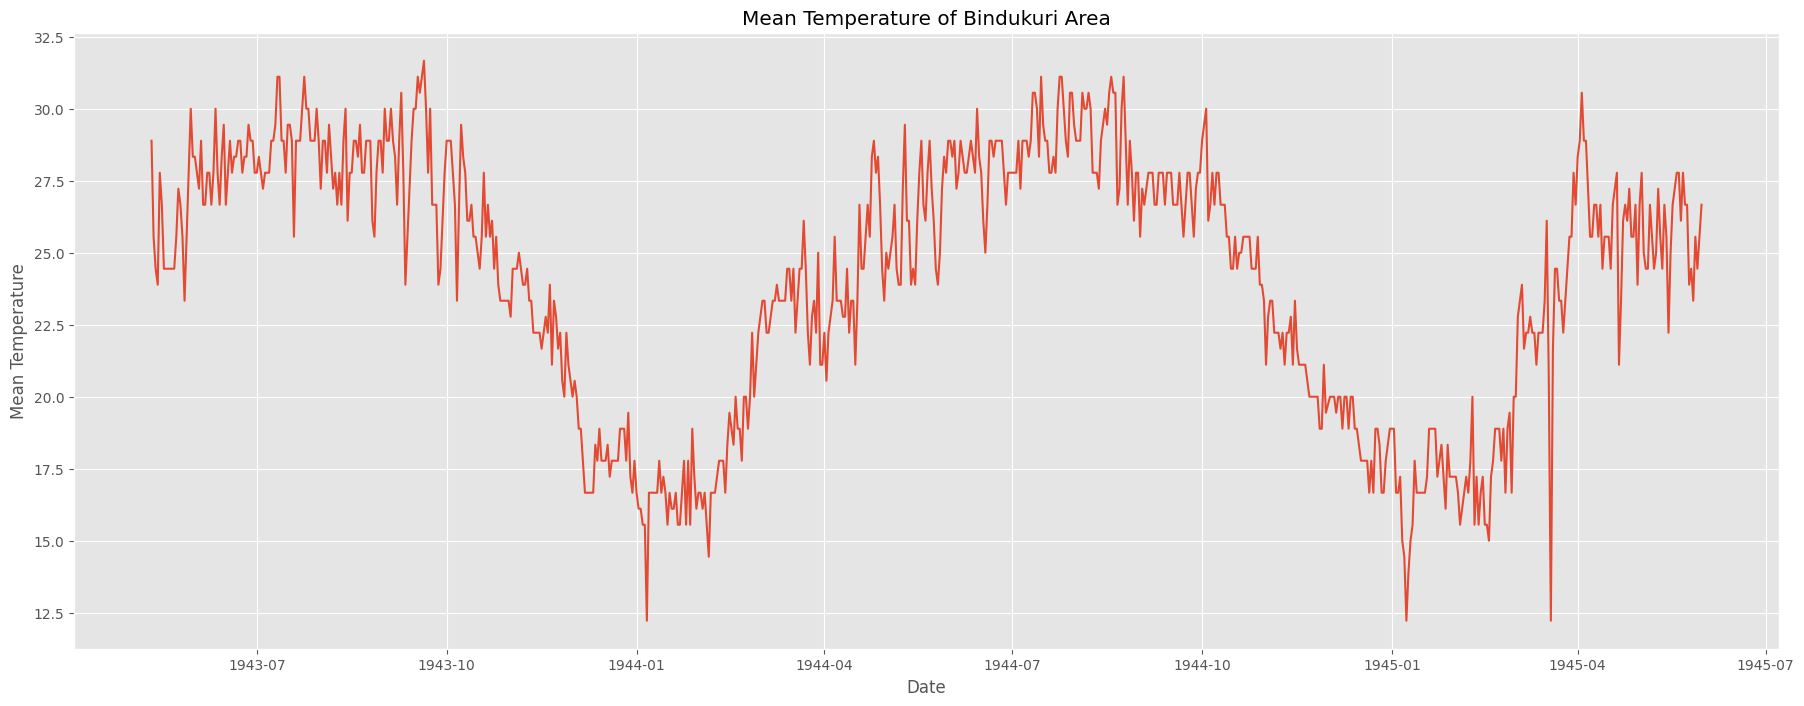

In [7]:
plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title('Mean Temperature of Bindukuri Area')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')

In [8]:
timeSeries = weather_bin.loc[:, ['Date', "MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop('Date', axis=1)
ts

,MeanTemp
Date,
1943-05-11,28.888889
1943-05-12,25.555556
1943-05-13,24.444444
1943-05-14,23.888889
1943-05-15,27.777778
...,...
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444


seasonal_decompose()를 활용하여 분해함

<Figure size 640x480 with 0 Axes>

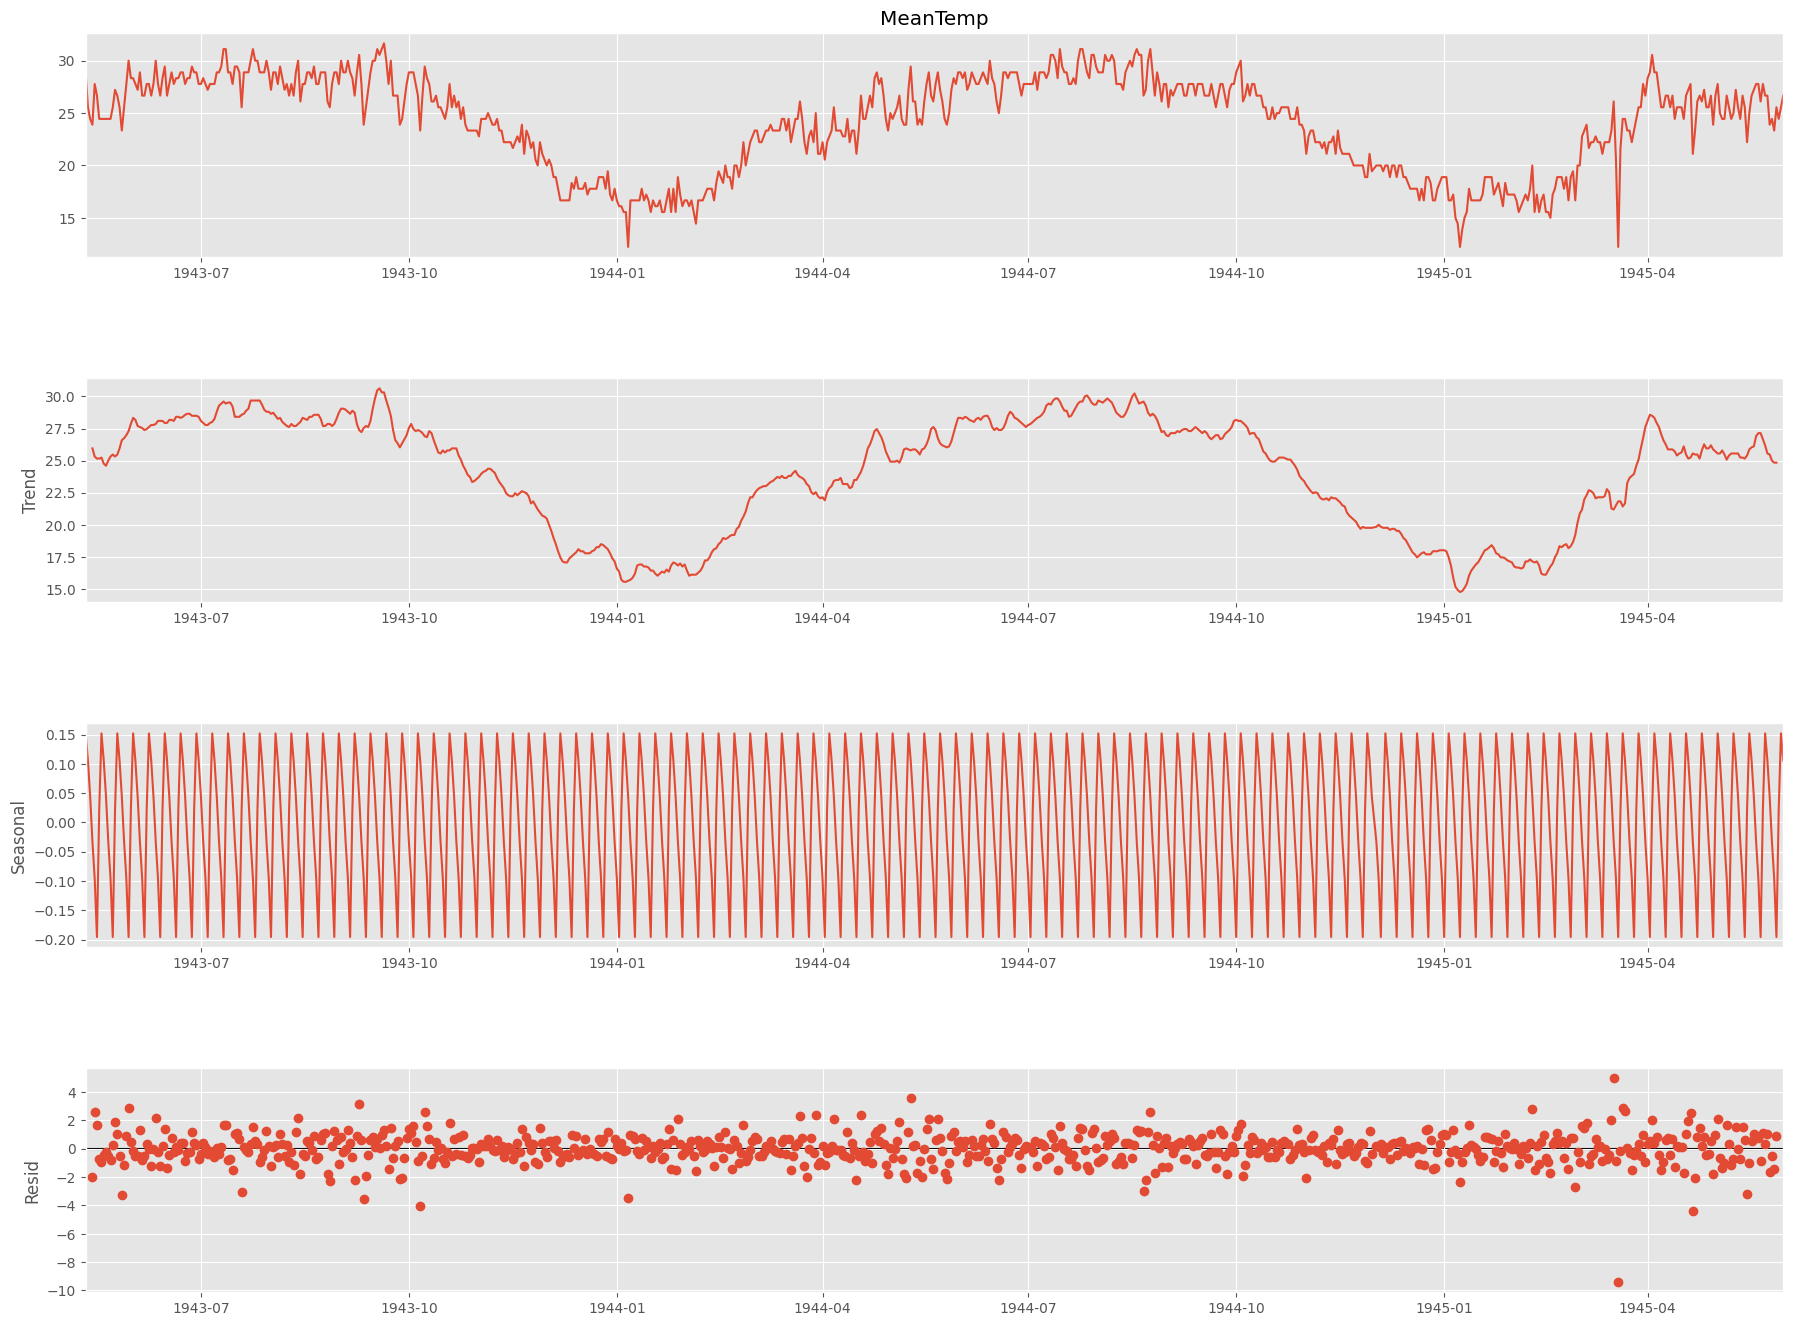

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts['MeanTemp'], model='additive',period = 7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

period에 들어가는 주기는 계절성 주기를 기반으로 설정해줌

정답이 있는 것은 아니라 분기별 데이터는 4, 월별 데이터는 12, 주별 패턴이 있는 일별 데이터는 7로 설정해본뒤 설정해보고 맞춰가는 것 추천

-> 데이터가 패턴이 보이기 때문에 정상성이 의심됨 (ACF 그래프로 확인)

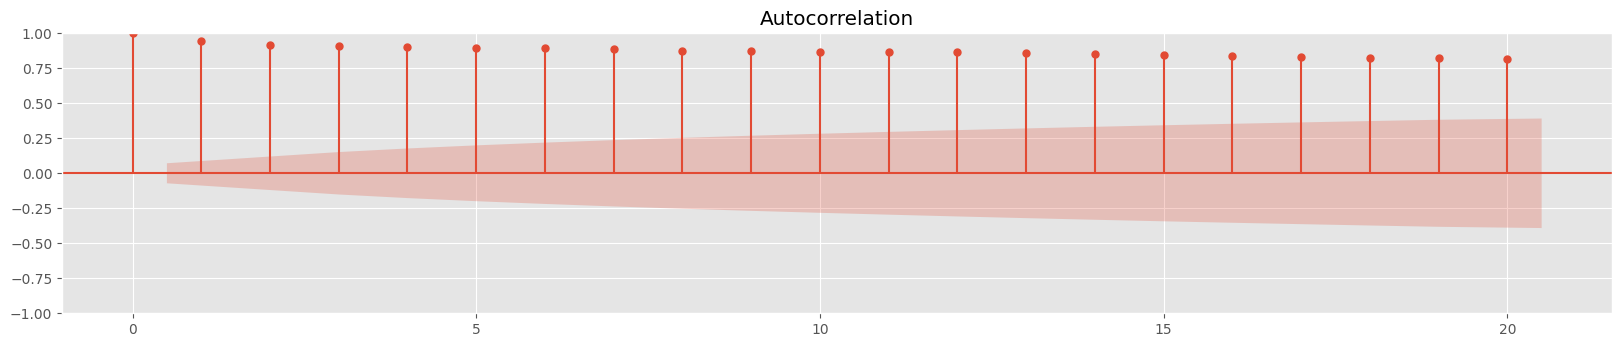

In [20]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

값이 천천히 작아지기 때문에 정상성을 만족하지 않는다고 판단함

ADF 검정
- 귀무가설 : 정상성을 만족하지 않는다.
- 대립가설 : 정상성을 만족한다.

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('Statistic : %.3f' %result[0])
print('p-value : %.3f' %result[1])
print('Critical Values :')
for key, value in result[4].items():
    print('\t%s : %.3f' %(key, value))

Statistic : -1.410
p-value : 0.578
Critical Values :
	1% : -3.439
	5% : -2.865
	10% : -2.569


p-value가 0.05보다 크기 때문에 귀무가설을 기각하지 못함

즉 데이터는 정상성을 만족하지 못함

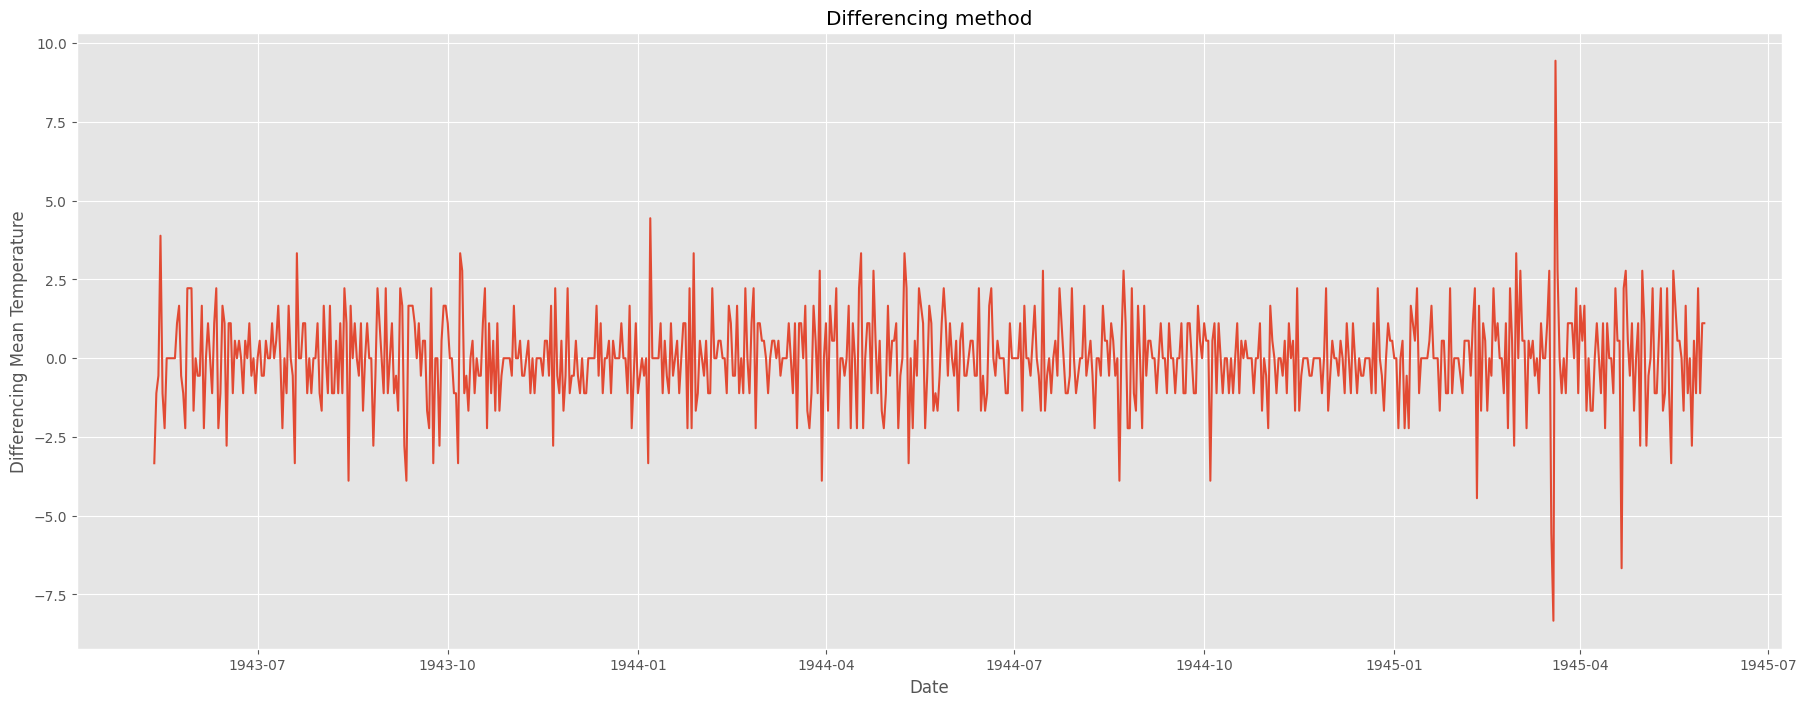

In [22]:
# 1차 차분
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,8))
plt.plot(ts_diff)
plt.title('Differencing method')
plt.xlabel('Date')
plt.ylabel('Differencing Mean Temperature')
plt.show()

일정한 패턴이 확인되지 않고 , 정상성을 만족하는 것처럼 보임

In [23]:
result = adfuller(ts_diff[1:])
print('Statistic : %.3f' %result[0])
print('p-value : %.3f' %result[1])
print('Critical Values :')
for key, value in result[4].items():
    print('\t%s : %.3f' %(key, value))

Statistic : -11.679
p-value : 0.000
Critical Values :
	1% : -3.439
	5% : -2.865
	10% : -2.569


p-value가 0.05보다 작으므로 귀무가설을 기각함

1차 차분한 데이터는 정상성을 만족함

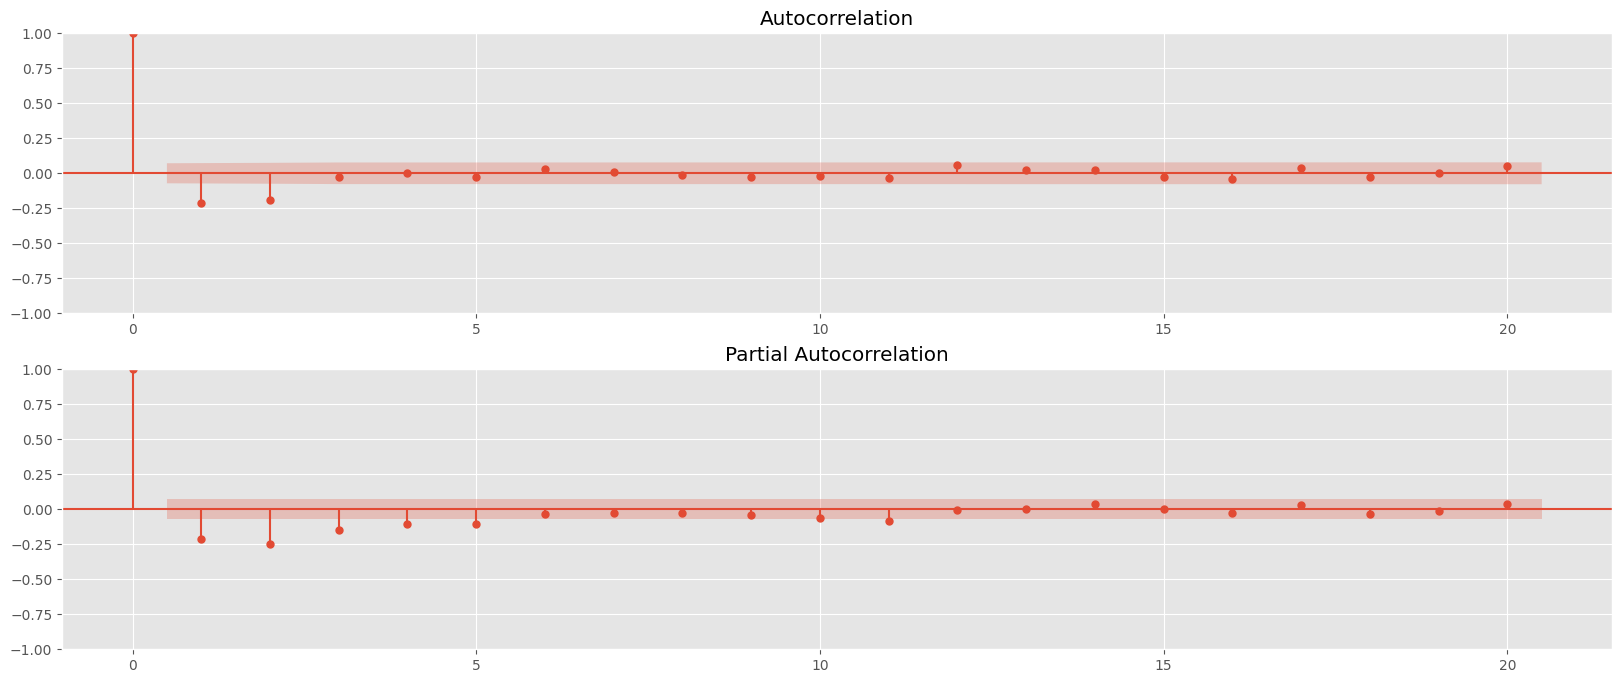

In [24]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

ACF와 PACF 모두 금방 0에 수렴하고 2번쨰 lag 이후 0에 수렴한다.

즉, ARIMA(2,1,2)모형을 base 모델로, 하여 다양한 모델을 시도해 볼 수 있다.

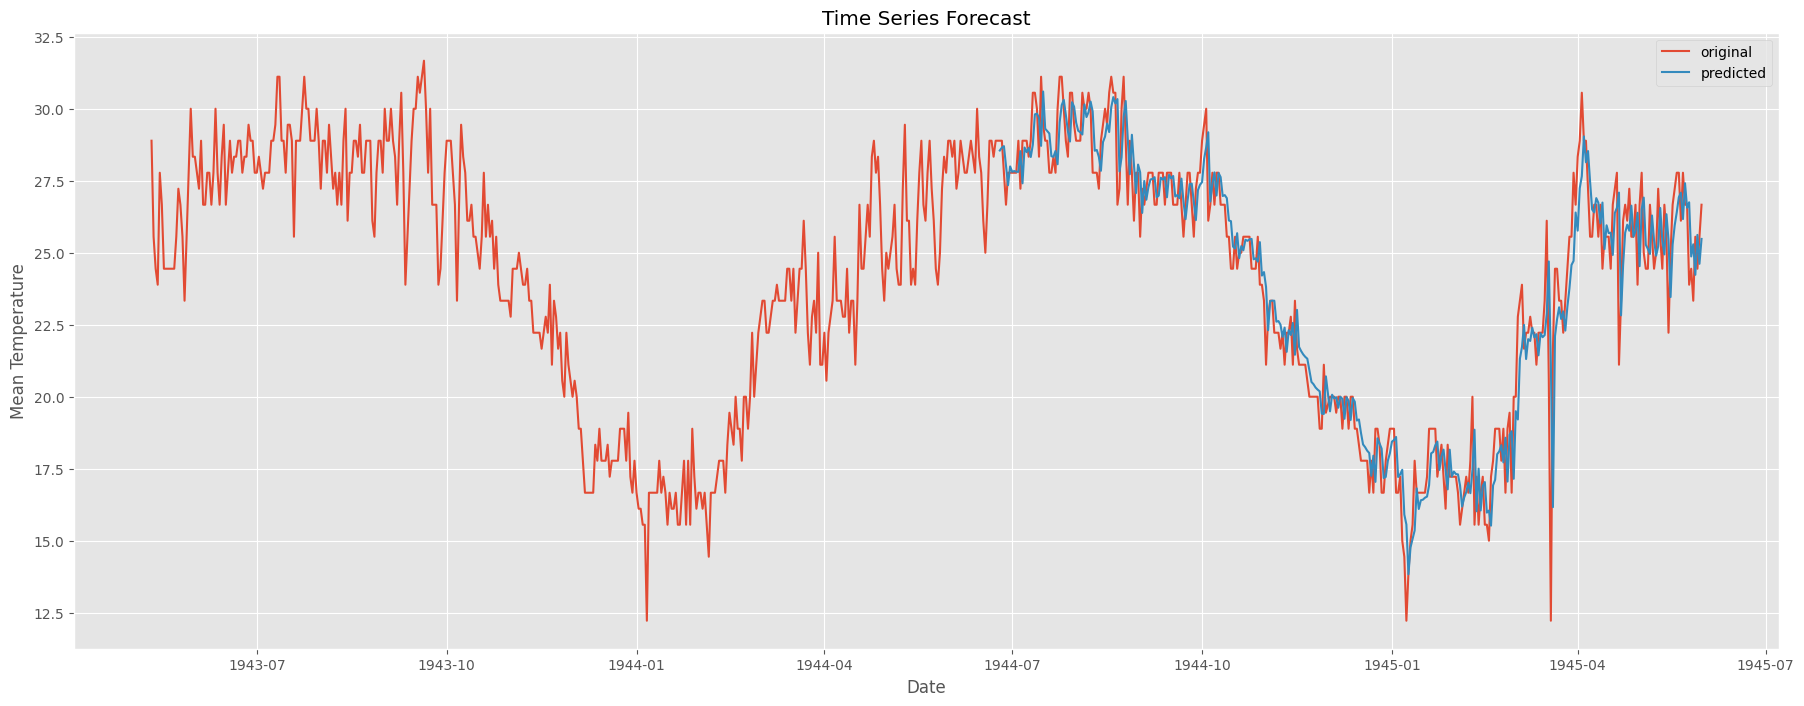

In [26]:
# ARIMA(2,1,2)
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()

#predict
start_index = datetime(1944, 6, 25)
end_index = datetime(1945, 5, 31)
forecast = model_fit.predict(start = start_index, end=end_index, typ='lavels')

plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date, weather_bin.MeanTemp,
         label='original')
plt.plot(forecast, label='predicted')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

위의 코드에서 주의할 점은 model fitting시 typ='levels'로 해주어야함

차분이 들어간 모델의 경우 typ을 default파라미터임 'linear'로 설정해줄 경우 차분한 값에 대한 결과가 나오기 때문이다.

#### 잔차분석
잔차에서는 어떠한 패턴이나 특성이 나타나서는 안됨

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


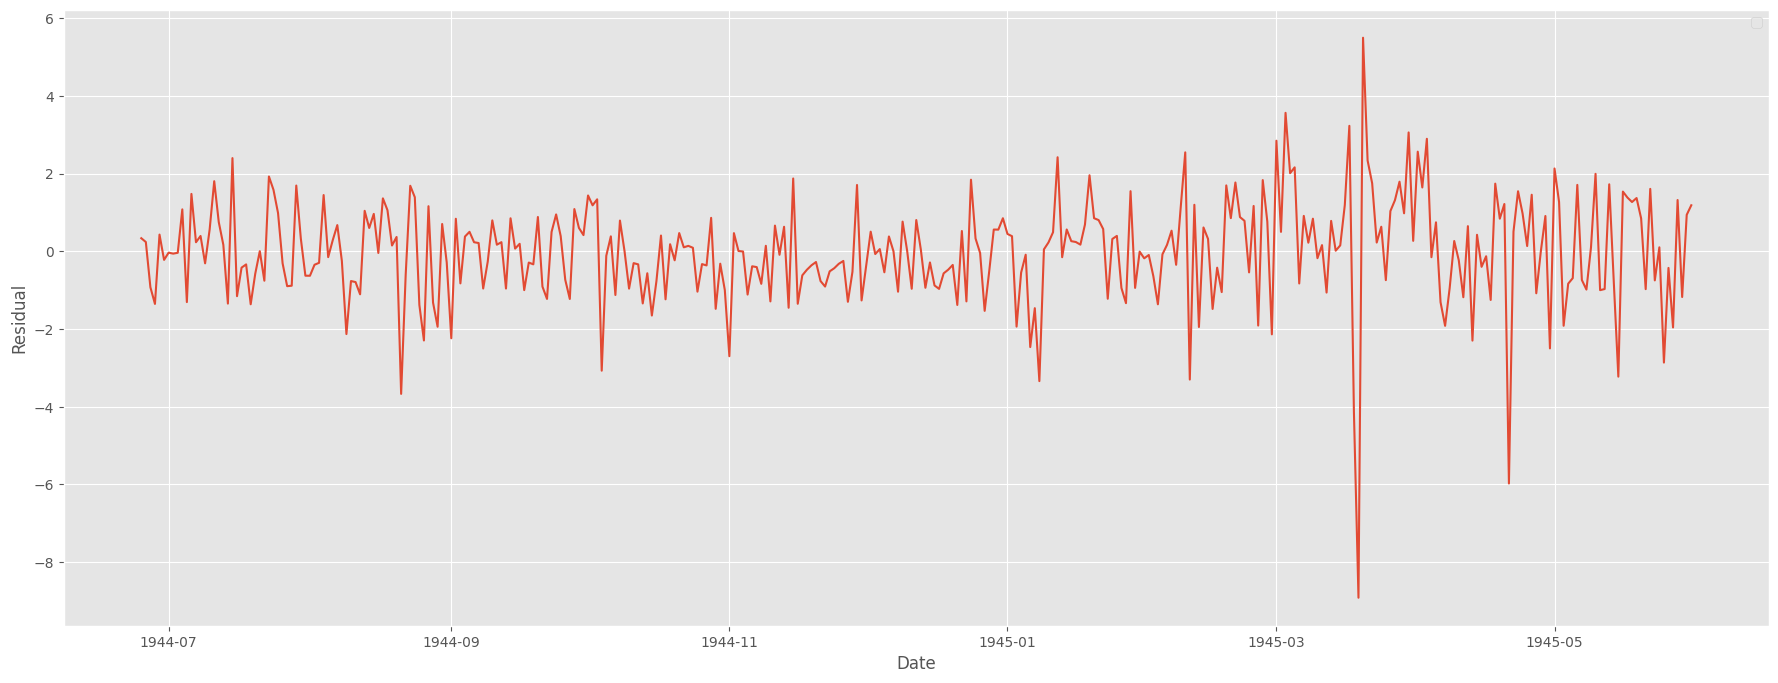

In [27]:
resi = np.array(weather_bin[weather_bin.Date >= start_index].MeanTemp)\
    - np.array(forecast)

plt.figure(figsize=(22,8))
plt.plot(weather_bin.Date[weather_bin.Date>=start_index], resi)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

ACF 그래프 및 ADF 검정을 통해 정상성도 판단

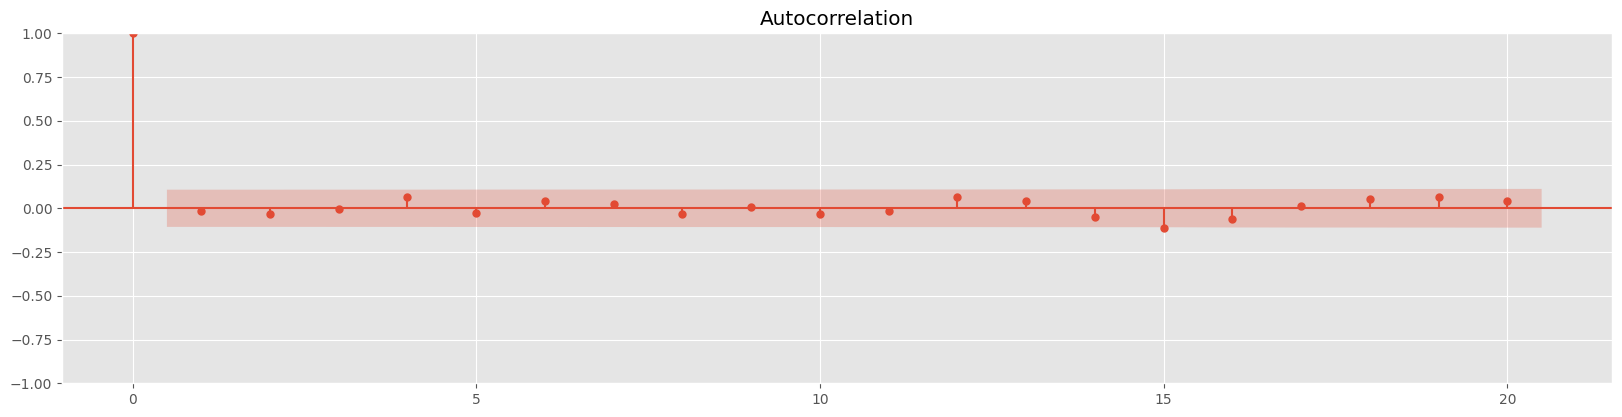

In [29]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [28]:
result = adfuller(resi)
print('Statistic : %.3f' %result[0])
print('p-value : %.3f' %result[1])
print('Critical Values :')
for key, value in result[4].items():
    print('\t%s : %.3f' %(key, value))

Statistic : -18.630
p-value : 0.000
Critical Values :
	1% : -3.450
	5% : -2.870
	10% : -2.571


ACF 그래프도 빠르게 0에 수렴하고 ADF 검정 역시 p-value가 작아 귀무가설 기각

In [31]:
# 성능 확인
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100,2)
    corr = round(np.corrcoef(y_true, y_pred)[0,1],3)
    mape = round(metrics.mean_absolute_error(y_true,y_pred)*100,3)
    rmse = round(metrics.mean_squared_error(y_true,y_pred,squared=False),3)
    
    df = pd.DataFrame({
        'R2':r2,
        'Corr':corr,
        'RMSE' : rmse,
        'MAPE':mape
    }, index=[0])
    return df

scoring(np.array(weather_bin[weather_bin.Date>=start_index].MeanTemp), np.array(forecast))

,R2,Corr,RMSE,MAPE
0,91.02,0.954,1.365,98.835
